### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [1]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle

Using TensorFlow backend.


In [2]:
project_data = pd.read_csv('preprocessed_data.csv')
project_data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [3]:
project_data = project_data.sample(n=100000, random_state=42)
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split

Y = project_data['project_is_approved']
project_data.drop(['project_is_approved'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(project_data, Y,stratify=Y,test_size=0.25,random_state=123)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train,stratify=y_train,test_size=0.25,random_state=123)

In [4]:
print("Train data shape:", x_train.shape)
print("cv data shape:", x_cv.shape)
print("Test data shape:", x_test.shape)

Train data shape: (56250, 9)
cv data shape: (18750, 9)
Test data shape: (25000, 9)


In [5]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(x_train["essay"])

vocab = vectorizer.get_feature_names()

In [6]:
print("Vocabulary length", len(vocab))

Vocabulary length 43794


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.essay)
encoded_docs_train = tokenizer.texts_to_sequences(x_train["essay"])
encoded_docs_cv = tokenizer.texts_to_sequences(x_cv["essay"])
encoded_docs_test = tokenizer.texts_to_sequences(x_test["essay"])

In [8]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

43831

In [9]:
max_length = 500

padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [10]:
print("Encoded train text shape:", padded_docs_train.shape)
print("Encoded cv text shape:", padded_docs_cv.shape)
print("Encoded test text shape:", padded_docs_test.shape)

Encoded train text shape: (56250, 500)
Encoded cv text shape: (18750, 500)
Encoded test text shape: (25000, 500)


In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(padded_docs_train)
padded_docs_train_stan = ss.transform(padded_docs_train)
padded_docs_cv_stan = ss.transform(padded_docs_cv)
padded_docs_test_stan = ss.transform(padded_docs_test)

In [12]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding Matrix Shape", embedding_matrix.shape)

Embedding Matrix Shape (43831, 300)


In [14]:
cat_sizes = {}

In [15]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["school_state"])

train_state = vect.transform(x_train["school_state"])
cv_state = vect.transform(x_cv["school_state"])
test_state = vect.transform(x_test["school_state"])
cat_sizes['school_state'] = len(vect.vocabulary_)

In [16]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["project_grade_category"])

train_project_grade_category = vect.transform(x_train["project_grade_category"])
cv_project_grade_category = vect.transform(x_cv["project_grade_category"])
test_project_grade_category = vect.transform(x_test["project_grade_category"])
cat_sizes['project_grade_category'] = len(vect.vocabulary_)

In [17]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["clean_categories"])

train_clean_categories = vect.transform(x_train["clean_categories"])
cv_clean_categories = vect.transform(x_cv["clean_categories"])
test_clean_categories = vect.transform(x_test["clean_categories"])
cat_sizes['clean_categories'] = len(vect.vocabulary_)

In [18]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["clean_subcategories"])

train_clean_subcategories = vect.transform(x_train["clean_subcategories"])
cv_clean_subcategories = vect.transform(x_cv["clean_subcategories"])
test_clean_subcategories = vect.transform(x_test["clean_subcategories"])
cat_sizes['clean_subcategories'] = len(vect.vocabulary_)

In [19]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["teacher_prefix"])

train_teacher_prefix = vect.transform(x_train["teacher_prefix"])
cv_teacher_prefix = vect.transform(x_cv["teacher_prefix"])
test_teacher_prefix = vect.transform(x_test["teacher_prefix"])
cat_sizes['teacher_prefix'] = len(vect.vocabulary_)

In [20]:
#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["school_state","project_grade_category", "clean_categories", "clean_subcategories", "teacher_prefix"]
cat_embsizes = {}
for cat in cat_vars:
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [21]:
rem_input_train = np.concatenate((x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1), x_train['price'].values.reshape(-1,1)), axis=1)
rem_input_cv = np.concatenate((x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1), x_cv['price'].values.reshape(-1,1)), axis=1)
rem_input_test = np.concatenate((x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1), x_test['price'].values.reshape(-1,1)), axis=1)

In [22]:
ss = StandardScaler().fit(rem_input_train)
rem_input_train_stan = ss.transform(rem_input_train)
rem_input_cv_stan = ss.transform(rem_input_cv)
rem_input_test_stan = ss.transform(rem_input_test)

In [23]:
from keras.utils import to_categorical

y_binary_train = to_categorical(y_train)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [24]:
from keras.regularizers import l2
from keras.layers import LeakyReLU
inputs = []
concat = []

text_input = Input(shape=(max_length,), name = "text_input")
inputs.append(text_input)
e1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(text_input)

l1= LSTM(256, kernel_initializer='he_normal', recurrent_dropout=0.5, kernel_regularizer=l2(0.001), return_sequences=True, activation='relu')(e1)
f1= Flatten()(l1)
concat.append(f1)

In [25]:
from keras.layers import Reshape

for cat in cat_vars:
    x = Input((cat_sizes[cat],), name=cat)
    inputs.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=cat_sizes[cat])(x)
    x = Flatten()(x)
    concat.append(x)

In [26]:
rem_input_layer =  Input((2,), name="rem_input_layer")
inputs.append(rem_input_layer)
rem_input_dense = Dense(128, activation='relu',kernel_initializer='he_normal')(rem_input_layer)
concat.append(rem_input_dense)

In [27]:
from keras.layers import Concatenate

x = Concatenate()(concat)
x= Dense(256, activation='relu', input_shape=(5,))(x)
x= Dropout(0.25)(x)
x= Dense(128, activation='relu')(x)
x= Dropout(0.5)(x)
x= Dense(64, activation='relu')(x)
output=Dense(2, activation='softmax')(x)
model_l = Model(inputs=inputs, outputs=output)

In [28]:
model_l.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     13149300    text_input[0][0]                 
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 51)           0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 4)            0                                            
__________________________________________________________________________________________________
clean_cate

In [29]:
#AUC score
from sklearn.metrics import accuracy_score
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, sample_weight=None).astype('float32'),
                    [y_true, y_pred],
                    'float32',
                    stateful=True,
                    name='sklearnAUC' )
    return score

In [30]:
import keras
model_l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 512

In [32]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from time import time

mcp_save = ModelCheckpoint('../working/mdl_wts.hdf5', save_best_only=True, monitor='accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='auto')
tb = TensorBoard(log_dir='../working/logs'.format(time()))

callbacks_lst = [mcp_save, reduce_lr_loss, tb]

In [34]:
model_l.fit(x={'text_input': padded_docs_train_stan.astype(np.float32), 'school_state': train_state, 'project_grade_category': train_project_grade_category,
                        'clean_categories': train_clean_categories,'clean_subcategories': train_clean_subcategories, 
                        'teacher_prefix': train_teacher_prefix, 'rem_input_layer':rem_input_train_stan.astype(np.float32)}, 
                       y=y_binary_train, epochs=10, batch_size=batch_size,verbose=1, 
                       validation_data=({'text_input': padded_docs_cv_stan.astype(np.float32), 'school_state': cv_state, 'project_grade_category': cv_project_grade_category,
                        'clean_categories': cv_clean_categories,'clean_subcategories': cv_clean_subcategories, 
                        'teacher_prefix': cv_teacher_prefix, 'rem_input_layer':rem_input_cv_stan.astype(np.float32)}, y_binary_cv),
                      callbacks=callbacks_lst)

Train on 56250 samples, validate on 18750 samples
Epoch 1/10
56250/56250 [==============================] - 103s 2ms/step - loss: 1.2815 - auc: 0.8664 - val_loss: 0.6305 - val_auc: 0.8806
Epoch 2/10
56250/56250 [==============================] - 99s 2ms/step - loss: 0.5003 - auc: 0.8780 - val_loss: 0.4444 - val_auc: 0.8818
Epoch 3/10
56250/56250 [==============================] - 99s 2ms/step - loss: 0.4220 - auc: 0.8814 - val_loss: 0.4230 - val_auc: 0.8821
Epoch 4/10
56250/56250 [==============================] - 100s 2ms/step - loss: 0.4132 - auc: 0.8844 - val_loss: 0.4218 - val_auc: 0.8815
Epoch 5/10
56250/56250 [==============================] - 100s 2ms/step - loss: 0.4084 - auc: 0.8887 - val_loss: 0.4191 - val_auc: 0.8805
Epoch 6/10
56250/56250 [==============================] - 100s 2ms/step - loss: 0.4050 - auc: 0.8926 - val_loss: 0.4183 - val_auc: 0.8796
Epoch 7/10
56250/56250 [==============================] - 100s 2ms/step - loss: 0.3988 - auc: 0.8980 - val_loss: 0.4249 - va

In [35]:
model_l.evaluate({'text_input': padded_docs_test_stan.astype(np.float32), 'school_state': test_state, 'project_grade_category': test_project_grade_category,
                        'clean_categories': test_clean_categories,'clean_subcategories': test_clean_subcategories, 
                        'teacher_prefix': test_teacher_prefix, 'rem_input_layer':rem_input_test_stan.astype(np.float32)}, y_binary_test)

25000/25000 [==============================] - 228s 9ms/step


[0.4701386535263061, 0.8694175]

In [ ]:
!tensorboard --logdir=../working/logs/

In [36]:
%load_ext tensorboard.notebook
%tensorboard --logdir=../working/logs/

* AUC  
<img src='Screenshot (240).png'>  
* Loss  
<img src='Screenshot (241).png'>

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data feature 'essay' <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [37]:
vectorizer = TfidfVectorizer(min_df=10,max_features=10000)
word_vector = vectorizer.fit(x_train.essay)

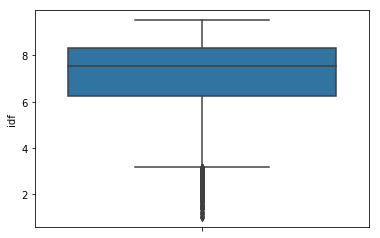

In [38]:
idf_values = vectorizer.idf_
sns.boxplot(y="idf", data=pd.DataFrame(idf_values, columns= ["idf"]))

In [39]:
for i in range(0,100,25):
    var = idf_values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1.0078349186743243
25 percentile value is 6.264255830514929
50 percentile value is 7.543129943013983
75 percentile value is 8.326661185042198
100 percentile value is  9.539683824888051


In [40]:
print("IDF values:", len(idf_values), ",Total featuers:", len(vectorizer.get_feature_names()))

IDF values: 10000 ,Total featuers: 10000


In [41]:
imp_words = {}
feature_list = vectorizer.get_feature_names()
for i in range(len(idf_values)):
    if idf_values[i] >= 6.26 and idf_values[i] <= 8.32:
        imp_words[feature_list[i]] = idf_values[i]

In [42]:
from tqdm import tqdm_notebook
x = imp_words.values()
def remove_words(sentences):
    imp_essay = []
    for sent in tqdm_notebook(sentences):
        lst = []
        for e in sent.lower().split():
            lst.append(e)
        imp_essay.append(' '.join(lst))
        lst.clear()
    return imp_essay

In [43]:
x_train_imp = remove_words(x_train.essay.tolist())
x_cv_imp = remove_words(x_cv.essay.tolist())
x_test_imp = remove_words(x_test.essay.tolist())

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_imp)
encoded_docs_train = tokenizer.texts_to_sequences(x_train_imp)
encoded_docs_cv = tokenizer.texts_to_sequences(x_cv_imp)
encoded_docs_test = tokenizer.texts_to_sequences(x_test_imp)

In [45]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

43831

In [46]:
max_length = 500

padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [47]:
print("Encoded train text shape:", padded_docs_train.shape)
print("Encoded cv text shape:", padded_docs_cv.shape)
print("Encoded test text shape:", padded_docs_test.shape)

Encoded train text shape: (56250, 500)
Encoded cv text shape: (18750, 500)
Encoded test text shape: (25000, 500)


In [48]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [49]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding Matrix Shape", embedding_matrix.shape)

Embedding Matrix Shape (43831, 300)


In [50]:
cat_sizes = {}

In [51]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["school_state"])

train_state = vect.transform(x_train["school_state"])
cv_state = vect.transform(x_cv["school_state"])
test_state = vect.transform(x_test["school_state"])
cat_sizes['school_state'] = len(vect.vocabulary_)

In [52]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["project_grade_category"])

train_project_grade_category = vect.transform(x_train["project_grade_category"])
cv_project_grade_category = vect.transform(x_cv["project_grade_category"])
test_project_grade_category = vect.transform(x_test["project_grade_category"])
cat_sizes['project_grade_category'] = len(vect.vocabulary_)

In [53]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["clean_categories"])

train_clean_categories = vect.transform(x_train["clean_categories"])
cv_clean_categories = vect.transform(x_cv["clean_categories"])
test_clean_categories = vect.transform(x_test["clean_categories"])
cat_sizes['clean_categories'] = len(vect.vocabulary_)

In [54]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["clean_subcategories"])

train_clean_subcategories = vect.transform(x_train["clean_subcategories"])
cv_clean_subcategories = vect.transform(x_cv["clean_subcategories"])
test_clean_subcategories = vect.transform(x_test["clean_subcategories"])
cat_sizes['clean_subcategories'] = len(vect.vocabulary_)

In [55]:
vect = CountVectorizer(binary=True)
vect.fit(x_train["teacher_prefix"])

train_teacher_prefix = vect.transform(x_train["teacher_prefix"])
cv_teacher_prefix = vect.transform(x_cv["teacher_prefix"])
test_teacher_prefix = vect.transform(x_test["teacher_prefix"])
cat_sizes['teacher_prefix'] = len(vect.vocabulary_)

In [56]:
#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["school_state","project_grade_category", "clean_categories", "clean_subcategories", "teacher_prefix"]
cat_embsizes = {}
for cat in cat_vars:
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [57]:
rem_input_train = np.concatenate((x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1), x_train['price'].values.reshape(-1,1)), axis=1)
rem_input_cv = np.concatenate((x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1), x_cv['price'].values.reshape(-1,1)), axis=1)
rem_input_test = np.concatenate((x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1), x_test['price'].values.reshape(-1,1)), axis=1)

In [58]:
from keras.utils import to_categorical

y_binary_train = to_categorical(y_train)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [59]:
from keras.regularizers import l2
from keras.layers import LeakyReLU
inputs = []
concat = []

text_input = Input(shape=(max_length,), name = "text_input")
inputs.append(text_input)
e1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(text_input)

l1= LSTM(256, kernel_initializer='he_normal', recurrent_dropout=0.5, kernel_regularizer=l2(0.001), return_sequences=True, activation='relu')(e1)
f1= Flatten()(l1)
concat.append(f1)

In [60]:
from keras.layers import Reshape

for cat in cat_vars:
    x = Input((cat_sizes[cat],), name=cat)
    inputs.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=cat_sizes[cat])(x)
    x = Flatten()(x)
    concat.append(x)

In [61]:
rem_input_layer =  Input((2,), name="rem_input_layer")
inputs.append(rem_input_layer)
rem_input_dense = Dense(128, activation='relu',kernel_initializer='he_normal')(rem_input_layer)
concat.append(rem_input_dense)

In [62]:
from keras.layers import Concatenate

x = Concatenate()(concat)
x= Dense(256, activation='relu', input_shape=(5,))(x)
x= Dropout(0.25)(x)
x= Dense(128, activation='relu')(x)
x= Dropout(0.5)(x)
x= Dense(64, activation='relu')(x)
output=Dense(2, activation='softmax')(x)
model_l = Model(inputs=inputs, outputs=output)

In [63]:
model_l.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 500, 300)     13149300    text_input[0][0]                 
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 51)           0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 4)            0                                            
__________________________________________________________________________________________________
clean_cate

In [64]:
#AUC score
from sklearn.metrics import accuracy_score
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, sample_weight=None).astype('float32'),
                    [y_true, y_pred],
                    'float32',
                    stateful=True,
                    name='sklearnAUC' )
    return score

In [65]:
import keras
model_l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

In [66]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 512

In [67]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from time import time

mcp_save = ModelCheckpoint('../working/mdl_wts.hdf5', save_best_only=True, monitor='accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='auto')
tb = TensorBoard(log_dir='../working/logs'.format(time()))

callbacks_lst = [mcp_save, reduce_lr_loss, tb]

In [69]:
model_l.fit(x={'text_input': padded_docs_train, 'school_state': train_state, 'project_grade_category': train_project_grade_category,
                        'clean_categories': train_clean_categories,'clean_subcategories': train_clean_subcategories, 
                        'teacher_prefix': train_teacher_prefix, 'rem_input_layer':rem_input_train}, 
                       y=y_binary_train, epochs=10, batch_size=batch_size,verbose=1, 
                       validation_data=({'text_input': padded_docs_cv, 'school_state': cv_state, 'project_grade_category': cv_project_grade_category,
                        'clean_categories': cv_clean_categories,'clean_subcategories': cv_clean_subcategories, 
                        'teacher_prefix': cv_teacher_prefix, 'rem_input_layer':rem_input_cv}, y_binary_cv),
                      callbacks=callbacks_lst)

Train on 56250 samples, validate on 18750 samples
Epoch 1/10
56250/56250 [==============================] - 103s 2ms/step - loss: 1.4036 - auc: 0.8449 - val_loss: 0.6199 - val_auc: 0.8488
Epoch 2/10
56250/56250 [==============================] - 101s 2ms/step - loss: 0.4983 - auc: 0.8475 - val_loss: 0.4388 - val_auc: 0.8488
Epoch 3/10
56250/56250 [==============================] - 103s 2ms/step - loss: 0.4318 - auc: 0.8481 - val_loss: 0.4258 - val_auc: 0.8488
Epoch 4/10
56250/56250 [==============================] - 102s 2ms/step - loss: 0.4266 - auc: 0.8496 - val_loss: 0.4250 - val_auc: 0.8488
Epoch 5/10
56250/56250 [==============================] - 101s 2ms/step - loss: 0.4267 - auc: 0.8479 - val_loss: 0.4249 - val_auc: 0.8488
Epoch 6/10
56250/56250 [==============================] - 102s 2ms/step - loss: 0.4262 - auc: 0.8490 - val_loss: 0.4250 - val_auc: 0.8488
Epoch 7/10
56250/56250 [==============================] - 102s 2ms/step - loss: 0.4261 - auc: 0.8482 - val_loss: 0.4248 - 

In [70]:
model_l.evaluate({'text_input': padded_docs_test, 'school_state': test_state, 'project_grade_category': test_project_grade_category,
                        'clean_categories': test_clean_categories,'clean_subcategories': test_clean_subcategories, 
                        'teacher_prefix': test_teacher_prefix, 'rem_input_layer':rem_input_test}, y_binary_test)

25000/25000 [==============================] - 232s 9ms/step


[0.42508111223220824, 0.8488]

In [71]:
%load_ext tensorboard.notebook
%tensorboard --logdir=../working/logs/

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


* AUC  
<img src='Screenshot (242).png'>  
* Loss  
<img src='Screenshot (243).png'>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [72]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train['price'].values.reshape(-1,1))

x_train_price_norm = normalizer.transform(x_train['price'].values.reshape(-1,1))
x_cv_price_norm = normalizer.transform(x_cv['price'].values.reshape(-1,1))
x_test_price_norm = normalizer.transform(x_test['price'].values.reshape(-1,1))

normalizer = Normalizer()
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_tpp_norm = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_cv_tpp_norm = normalizer.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_tpp_norm = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [73]:
from scipy.sparse import hstack

x_tr_rem = hstack((train_state, train_teacher_prefix, train_project_grade_category, train_clean_subcategories, train_clean_categories, x_train_price_norm, x_train_tpp_norm)).todense()
x_cv_rem = hstack((cv_state, cv_teacher_prefix, cv_project_grade_category, cv_clean_subcategories, cv_clean_categories, x_cv_price_norm, x_cv_tpp_norm)).todense()
x_te_rem = hstack((test_state, test_teacher_prefix, test_project_grade_category, test_clean_subcategories,test_clean_categories, x_test_price_norm, x_test_tpp_norm)).todense()

print("Final Data matrix")
print(x_tr_rem.shape, y_train.shape)
print(x_cv_rem.shape, y_cv.shape)
print(x_te_rem.shape, y_test.shape)

Final Data matrix
(56250, 101) (56250,)
(18750, 101) (18750,)
(25000, 101) (25000,)


In [74]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.essay)
encoded_docs_train = tokenizer.texts_to_sequences(x_train["essay"])
encoded_docs_cv = tokenizer.texts_to_sequences(x_cv["essay"])
encoded_docs_test = tokenizer.texts_to_sequences(x_test["essay"])

In [75]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

43831

In [76]:
max_length = 500

padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [77]:
print("Encoded train text shape:", padded_docs_train.shape)
print("Encoded cv text shape:", padded_docs_cv.shape)
print("Encoded test text shape:", padded_docs_test.shape)

Encoded train text shape: (56250, 500)
Encoded cv text shape: (18750, 500)
Encoded test text shape: (25000, 500)


In [78]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [79]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding Matrix Shape", embedding_matrix.shape)

Embedding Matrix Shape (43831, 300)


In [80]:
text_input = Input(shape=(500,), name = "text_input")
e1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=500)(text_input)
l1= LSTM(128,activation = "relu",dropout=0.5,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal',return_sequences=True,input_shape=(150,300))(e1)
f1= Flatten()(l1)

rem = Input(shape=(x_tr_rem.shape[1],1), name="rem")
rem_conv1 = Conv1D(128, 3, activation='relu', kernel_initializer='glorot_normal')(rem)
rem_conv2 =Conv1D(64, 3, activation='relu',kernel_initializer='glorot_normal' )(rem_conv1)
f2= Flatten()(rem_conv2)
x = keras.layers.concatenate([f1,f2])
x= Dense(256, activation='sigmoid')(x)
x= Dropout(0.25)(x)
x= Dense(128, kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
output=Dense(2, activation='softmax')(x)
model_3 = Model(inputs=[text_input,rem], outputs=output)
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
rem (InputLayer)                (None, 101, 1)       0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 500, 300)     13149300    text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 128)      512         rem[0][0]                        
__________________________________________________________________________________________________
lstm_3 (LS

In [81]:
#AUC score
from sklearn.metrics import accuracy_score
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, sample_weight=None).astype('float32'),
                    [y_true, y_pred],
                    'float32',
                    stateful=True,
                    name='sklearnAUC' )
    return score

In [82]:
import keras
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

In [83]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from time import time

mcp_save = ModelCheckpoint('../working/mdl_wts.hdf5', save_best_only=True, monitor='accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='auto')
tb = TensorBoard(log_dir='../working/logs'.format(time()))

callbacks_lst = [mcp_save, reduce_lr_loss, tb]

In [85]:
x_tr_rem_reshape = np.array(x_tr_rem).reshape(56250,101,1)
x_cv_rem_reshape = np.array(x_cv_rem).reshape(18750, 101,1)
x_test_rem_reshape = np.array(x_te_rem).reshape(25000, 101,1)

In [86]:
model_3.fit({'text_input': padded_docs_train, 'rem':x_tr_rem_reshape}, y_binary_train, epochs=10, batch_size=batch_size,
             verbose=1, validation_data=({'text_input': padded_docs_cv, 'rem': x_cv_rem_reshape},y_binary_cv),
             callbacks=callbacks_lst)

Train on 56250 samples, validate on 18750 samples
Epoch 1/10
56250/56250 [==============================] - 112s 2ms/step - loss: 1.1782 - auc: 0.8426 - val_loss: 0.6652 - val_auc: 0.9002
Epoch 2/10
56250/56250 [==============================] - 107s 2ms/step - loss: 0.6237 - auc: 0.8991 - val_loss: 0.5941 - val_auc: 0.9083
Epoch 3/10
56250/56250 [==============================] - 108s 2ms/step - loss: 0.5762 - auc: 0.9087 - val_loss: 0.5610 - val_auc: 0.9103
Epoch 4/10
56250/56250 [==============================] - 107s 2ms/step - loss: 0.5392 - auc: 0.9138 - val_loss: 0.5356 - val_auc: 0.9103
Epoch 5/10
56250/56250 [==============================] - 108s 2ms/step - loss: 0.5100 - auc: 0.9173 - val_loss: 0.5161 - val_auc: 0.9099
Epoch 6/10
56250/56250 [==============================] - 110s 2ms/step - loss: 0.4825 - auc: 0.9210 - val_loss: 0.5011 - val_auc: 0.9088
Epoch 7/10
56250/56250 [==============================] - 107s 2ms/step - loss: 0.4560 - auc: 0.9256 - val_loss: 0.4855 - 

In [87]:
model_3.evaluate({'text_input': padded_docs_test, 'rem': x_test_rem_reshape}, y_binary_test)

25000/25000 [==============================] - 245s 10ms/step


[nan, 0.86573375]

In [88]:
%load_ext tensorboard.notebook
%tensorboard --logdir=../working/logs/

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


## Conclusion

In [89]:
from prettytable import PrettyTable
pt=PrettyTable()
pt.field_names=["model","test_auc"]
pt.add_row(["model_1", 0.8694])
pt.add_row(["model_2", 0.8488])
pt.add_row(["model_3", 0.8657])

print(pt)

+---------+----------+
|  model  | test_auc |
+---------+----------+
| model_1 |  0.8694  |
| model_2 |  0.8488  |
| model_3 |  0.8657  |
+---------+----------+
